# One layer NN

In [1]:
import copy
import os

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as npl
from sklearn import datasets
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm as tqdm

In [2]:
# Plot params
# mpl.style.use("seaborn-dark")
mpl.style.use("ggplot")
mpl.rcParams["axes.grid"] = True
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["axes.labelsize"] = "large"
mpl.rcParams["text.usetex"] = True
# plt.rcParams["ytick.major.size"] = 5.0
# plt.rcParams["ytick.minor.size"] = 3.0
mpl.rcParams["font.size"] = 14
plt.rcParams["legend.framealpha"] = 0.9
w, h = plt.rcParams.get("figure.figsize")
figsize = (w, 5/8 * h)

os.makedirs("../outputs/visualizations", exist_ok=True)

In [3]:
# Numeric pNML
def add_to_test(x_train, y_train, x, y):
    return np.concatenate((x_train, x)), np.concatenate((y_train, y))


def fit_mlp(phi_train, y_train, initial_clf=None):
    if initial_clf is None:
        clf = MLPClassifier(
            solver="sgd",
            alpha=0.0,
            hidden_layer_sizes=(2,),
            random_state=0,
            max_iter=10000,
            activation="identity",
        ).fit(phi_train, y_train)
    else:
        clf = initial_clf.fit(phi_train, y_train)
    return clf


def calc_numerical_regres(
    phi_train: np.ndarray, y_train: np.ndarray, phi_test: np.ndarray
) -> np.ndarray:
    regret_list = []
    clf_erm = fit_mlp(phi_train, y_train)
    for phi in tqdm(phi_test):
        phi = np.expand_dims(phi, 0)

        phi_all, y_all = add_to_test(phi_train, y_train, phi, np.array([0]))
        clf = fit_mlp(phi_all, y_all, copy.deepcopy(clf_erm))
        p0 = clf.predict_proba(phi)[0][0]

        phi_all, y_all = add_to_test(phi_train, y_train, phi, np.array([1]))
        clf = fit_mlp(phi_all, y_all, copy.deepcopy(clf_erm))
        p1 = clf.predict_proba(phi)[0][1]

        regret = np.log2(p0 + p1)
        regret_list.append(regret)
    return np.asarray(regret_list)


def add_bias(x):
    n = x.shape[0]
    ones = np.expand_dims(np.ones(n), 1)
    return np.hstack((x, ones))


def create_testset(array_1, array_2):
    mesh = np.array(np.meshgrid(array_1, array_2))
    combinations = mesh.T.reshape(-1, 2)
    return add_bias(combinations)

# IRIS dataset

In [4]:
# import some data to play with
iris = datasets.load_iris()
x_train = iris.data[:, :2]  # we only take the first two features.
x_train = add_bias(x_train)
y_train = iris.target

# Get only label 0 and 1
x_train = x_train[y_train != 1]
y_train = y_train[y_train != 1]
y_train[y_train == 2] = 1

# Reduce number of training set
x_train = x_train[::6]
y_train = y_train[::6]

x1_min, x1_max = x_train[:, 0].min() - 0.5, x_train[:, 0].max() + 0.5
x2_min, x2_max = x_train[:, 1].min() - 0.5, x_train[:, 1].max() + 0.5

x_test = create_testset(
    np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100)
)

## Fit

In [5]:
clf_erm = fit_mlp(x_train, y_train)
erm_probs = clf_erm.predict_proba(x_test)

In [6]:
# Analytical pNML
regrets = []
x_t_gs = []
pnml_probs = []
n, m = x_train.shape

X_inv = npl.pinv(x_train)
P_bot = np.eye(m) - X_inv @ x_train

for x, probs_i in zip(x_test, erm_probs):
    # Convert to column vec
    x = np.expand_dims(x, 1)
    x = x / npl.norm(x, keepdims=True)
    x_bot = P_bot @ x
    x_bot_square = float(x_bot.T @ x_bot) ** 2

    x_parallel = float(x.T @ X_inv @ X_inv.T @ x)
    if x_bot_square > np.finfo("float").eps:
        x_t_g = phi.T @ x_bot
    else:  # x_bot =0
        x_t_g = x_parallel / (1 + x_parallel)

    genies_i = probs_i / (probs_i + (1 - probs_i) * (probs_i ** x_t_g))
    nf = np.sum(genies_i)
    regret_i = float(np.log2(nf))
    regrets.append(regret_i)
    x_t_gs.append(x_t_g)
    pnml_probs.append(genies_i / nf)

pnml_probs = np.asarray(pnml_probs).squeeze()
x_t_gs = np.asarray(x_t_gs).squeeze()
regrets = np.asarray(regrets).squeeze()

## Plot

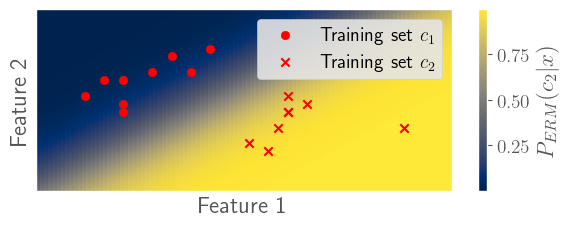

3.9000000000000004 8.2
2.0 4.3


In [7]:
neg_idx = np.where(y_train == 0)[0]
pos_idx = np.where(y_train == 1)[0]

# ERM prob
fig, ax = plt.subplots(1, 1, figsize=figsize)
im = ax.scatter(x_test[:, 0], x_test[:, 1], c=erm_probs[:, 1], cmap="cividis")
ax.scatter(
    x_train[neg_idx, 0],
    x_train[neg_idx, 1],
    marker="o",
    color="r",
    label=r"Training set $c_1$",
)
ax.scatter(
    x_train[pos_idx, 0],
    x_train[pos_idx, 1],
    marker="x",
    color="r",
    label=r"Training set $c_2$",
)
ax.set_xlabel(r"Feature 1")
ax.set_ylabel(r"Feature 2")
fig.colorbar(im, label=r"$P_{ERM}(c_2|x)$", ax=ax)
ax.legend(loc=1)
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
ax.set_xticks([])
ax.set_xticks([], minor=True)
ax.set_yticks([])
ax.set_yticks([], minor=True)

plt.tight_layout()
plt.savefig("../outputs/visualizations/syntetic_erm_prob.pdf")
plt.show()

print(x1_min, x1_max)
print(x2_min, x2_max)

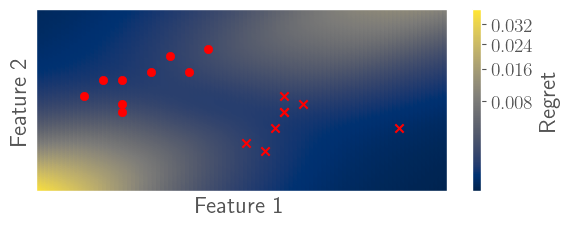

In [8]:
# Regret
fig, ax = plt.subplots(1, 1, sharex=True, figsize=figsize)
im = ax.scatter(
    x_test[:, 0],
    x_test[:, 1],
    c=regrets,
    cmap="cividis",
    norm=matplotlib.colors.PowerNorm(gamma=0.45),
)

ax.scatter(
    x_train[neg_idx, 0], x_train[neg_idx, 1], marker="o", color="r", label="Class 0"
)
ax.scatter(
    x_train[pos_idx, 0], x_train[pos_idx, 1], marker="x", color="r", label="Class 1"
)
ax.set_xlabel(r"Feature 1")
ax.set_ylabel(r"Feature 2")
cb = fig.colorbar(im, label="Regret", ax=ax)
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)

ax.set_xticks([])
ax.set_xticks([], minor=True)
ax.set_yticks([])
ax.set_yticks([], minor=True)

# (generate plot here)
from matplotlib import ticker

tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

plt.tight_layout()
plt.savefig("../outputs/visualizations/syntetic_regret.pdf")
plt.show()

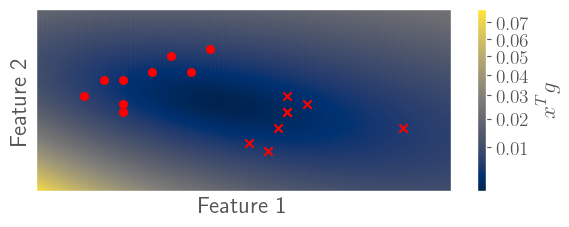

In [9]:
# Regret
fig, ax = plt.subplots(1, 1, sharex=True, figsize=figsize)
im = ax.scatter(
    x_test[:, 0],
    x_test[:, 1],
    c=x_t_gs,
    cmap="cividis",
    norm=matplotlib.colors.PowerNorm(gamma=0.65),
)

ax.scatter(
    x_train[neg_idx, 0], x_train[neg_idx, 1], marker="o", color="r", label="Class 0"
)
ax.scatter(
    x_train[pos_idx, 0], x_train[pos_idx, 1], marker="x", color="r", label="Class 1"
)
ax.set_xlabel(r"Feature 1")
ax.set_ylabel(r"Feature 2")
fig.colorbar(im, label=r"$x^T g$", ax=ax)
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)

ax.set_xticks([])
ax.set_xticks([], minor=True)
ax.set_yticks([])
ax.set_yticks([], minor=True)
plt.tight_layout()
plt.savefig("../outputs/visualizations/syntetic_x_t_gs.pdf")
plt.show()

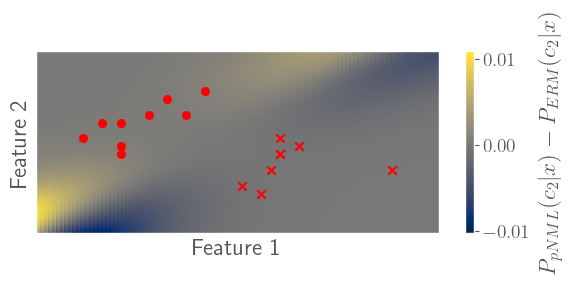

In [10]:
# Regret
fig, ax = plt.subplots(1, 1, sharex=True, figsize=figsize)
im = ax.scatter(
    x_test[:, 0], x_test[:, 1], c=pnml_probs[:, 1] - erm_probs[:, 1], cmap="cividis"
)

ax.scatter(
    x_train[neg_idx, 0], x_train[neg_idx, 1], marker="o", color="r", label="Class 0"
)
ax.scatter(
    x_train[pos_idx, 0], x_train[pos_idx, 1], marker="x", color="r", label="Class 1"
)
ax.set_xlabel(r"Feature 1")
ax.set_ylabel(r"Feature 2")
fig.colorbar(im, label=r"$ P_{pNML}(c_2|x) - P_{ERM}(c_2|x)$", ax=ax)
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)

ax.set_xticks([])
ax.set_xticks([], minor=True)
ax.set_yticks([])
ax.set_yticks([], minor=True)
plt.tight_layout()
plt.savefig("../outputs/visualizations/syntetic_pnml_prob.pdf")
plt.show()